In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from fastai.data.core import DataLoaders

from scripts.utils import *
import scripts.pp_cnf_matrix as ppcm

In [2]:
sns.set("notebook", "whitegrid")

In [3]:
test_set = ECGDataset("./data/heartbeats_evensplit_test/", target_transform=label_encode)
model = TCN(360, 5, [32]*9, 2, 0.125, use_skip_connections=True)
model.load_state_dict(torch.load("./models/prototyping8/tcn_fold_4/best.pth"))
target_layer = model.tcn.network[-1].conv2

In [4]:
model_outputs = iterate_perturbations(test_set, model, target_layer, 10, 2048, 0.25, save_directory="./models/prototyping8/")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

c:\Users\chris\.virtualenvs\AAI1001-GKVhCZq-\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

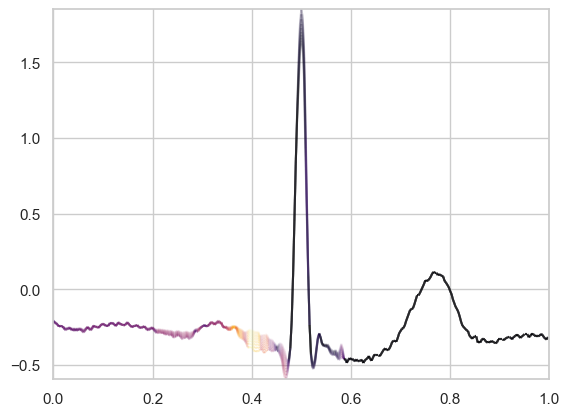

In [3]:
fig, ax = plt.subplots()
x = np.arange(0, 1, 1/360)
model_outputs = []
SIGNAL_IDX = 0
for i in tqdm(range(10)):
    model_output = np.load(f"./models/prototyping6/perturbed_data_{i}.npz")
    proba, y = model_output["proba"], model_output["y"]
    model_outputs.append({"proba": proba, "y": y})
    signal = model_output["inputs"][SIGNAL_IDX]
    greyscale_cam = model_output["cams"][SIGNAL_IDX]
    points = np.array([x, signal]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(greyscale_cam.min(), greyscale_cam.max())
    lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=(0.25 * 0.9**i))
    lc.set_array(greyscale_cam.T)
    line = ax.add_collection(lc)
    # fig.colorbar(line, ax=ax)
    # print(model_outputs[i]["inputs"][0][180])
    # ax.plot(x, model_outputs[i]["inputs"][0], alpha=0.1)
    ax.set_ylim(min(ax.get_ylim()[0], min(signal)), max(ax.get_ylim()[1], max(signal)))

# ax.set_ylim(-1.5, 3)
plt.show()

In [5]:
# find first of each class
first_of_each_class = []
for i in range(10):
    for j in range(5):
        first_of_each_class.append(np.where(model_outputs[i]["y"] == j)[0][0])
    break
first_of_each_class

[0, 1353, 2365, 6806, 2083]

  0%|          | 0/10 [00:00<?, ?it/s]

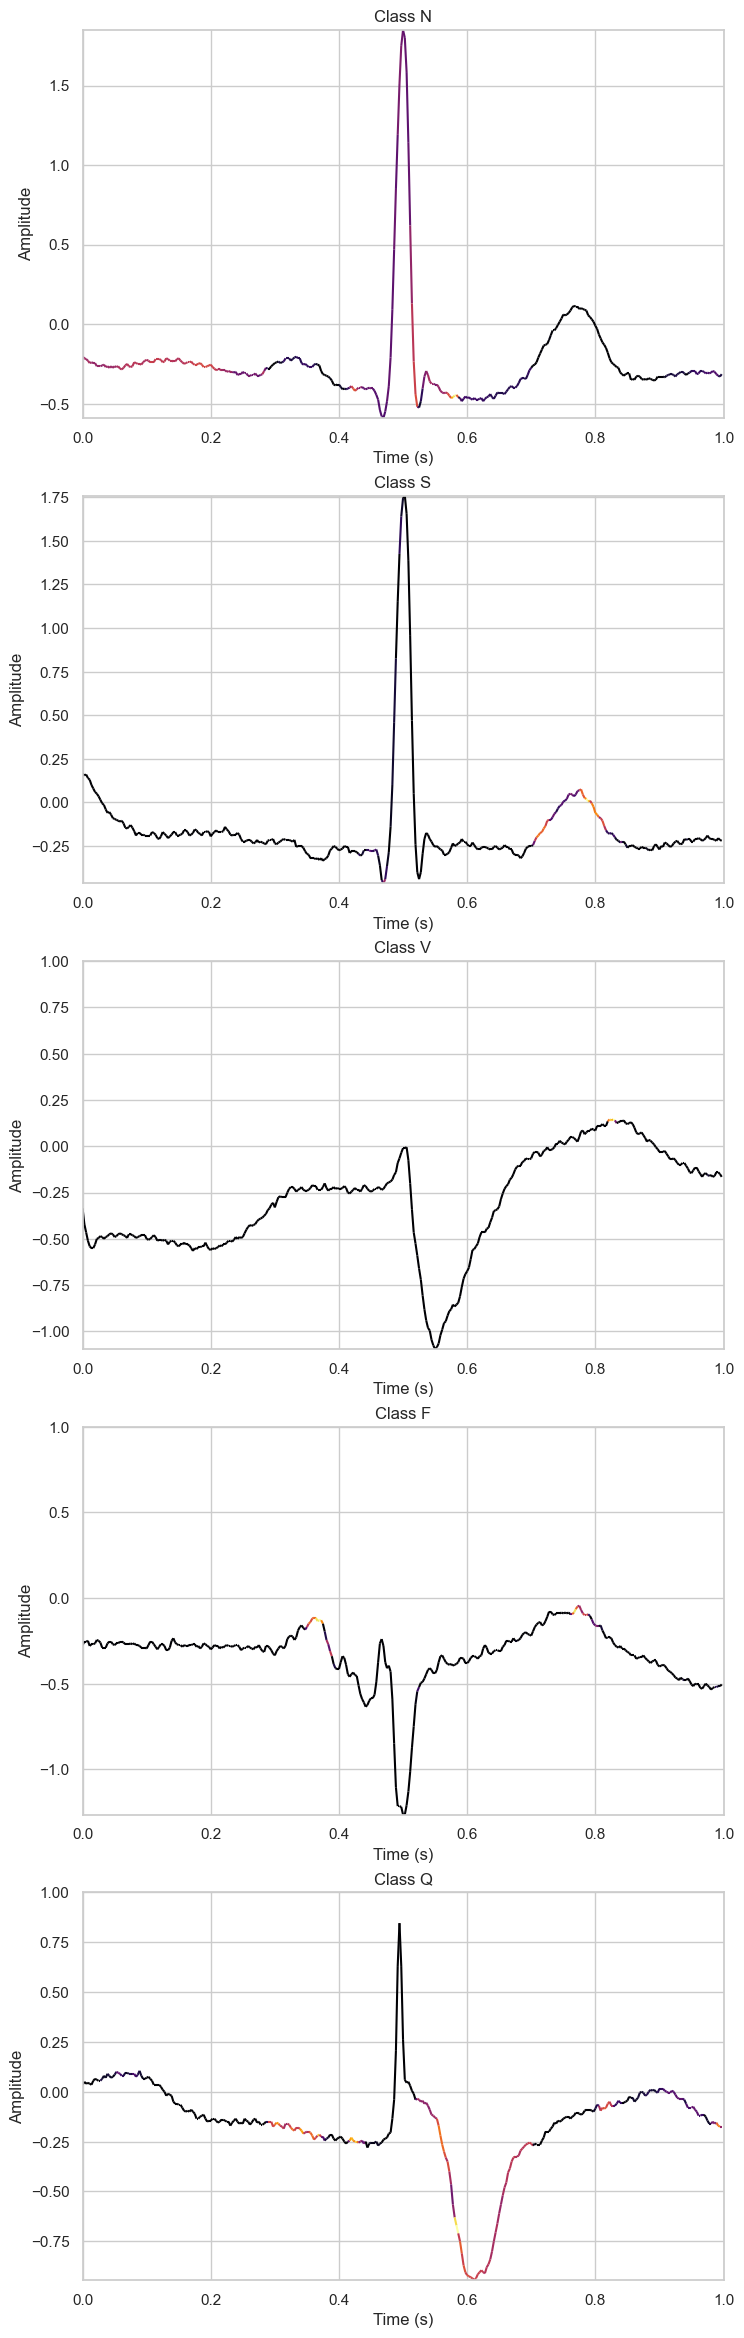

In [7]:
x = np.arange(0, 1, 1/360)
fig, ax = plt.subplots(5, 1, figsize=(8.27, 29.225), dpi=100)
for perturb_iter in tqdm(range(10)):
    model_output = np.load(f"./models/prototyping8/perturbed_data_{perturb_iter}.npz")
    for i, signal_idx in enumerate(first_of_each_class):
        signal = model_output["inputs"][signal_idx]
        greyscale_cam = model_output["cams"][signal_idx]
        points = np.array([x, signal]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(greyscale_cam.min(), greyscale_cam.max())
        lc = LineCollection(segments, cmap='inferno', norm=norm)
        lc.set_array(greyscale_cam.T)
        line = ax[i].add_collection(lc)
        # fig.colorbar(line, ax=ax)
        # print(model_outputs[i]["inputs"][0][180])
        # ax.plot(x, model_outputs[i]["inputs"][0], alpha=0.1)
        ax[i].set_ylim(
            min(ax[i].get_ylim()[0], min(signal)),
            max(ax[i].get_ylim()[1], max(signal))
        )
    break

for i, classi in enumerate(["N", "S", "V", "F", "Q"]):
    ax[i].set_title(f"Class {classi}")
    ax[i].set_ylabel("Amplitude")
    ax[i].set_xlabel("Time (s)")

  0%|          | 0/10 [00:00<?, ?it/s]

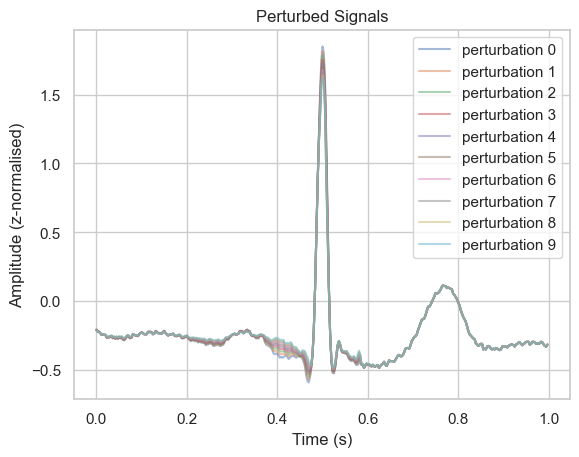

In [8]:
fig, ax = plt.subplots()
x = np.arange(0, 1, 1/360)
SIGNAL_IDX = 0
for i in tqdm(range(10)):
    model_output = np.load(f"./models/prototyping6/perturbed_data_{i}.npz")
    signal = model_output["inputs"][SIGNAL_IDX]
    ax.plot(x, signal, alpha=.5, label=f"perturbation {i}")
    
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (z-normalised)")
ax.set_title("Perturbed Signals")
ax.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

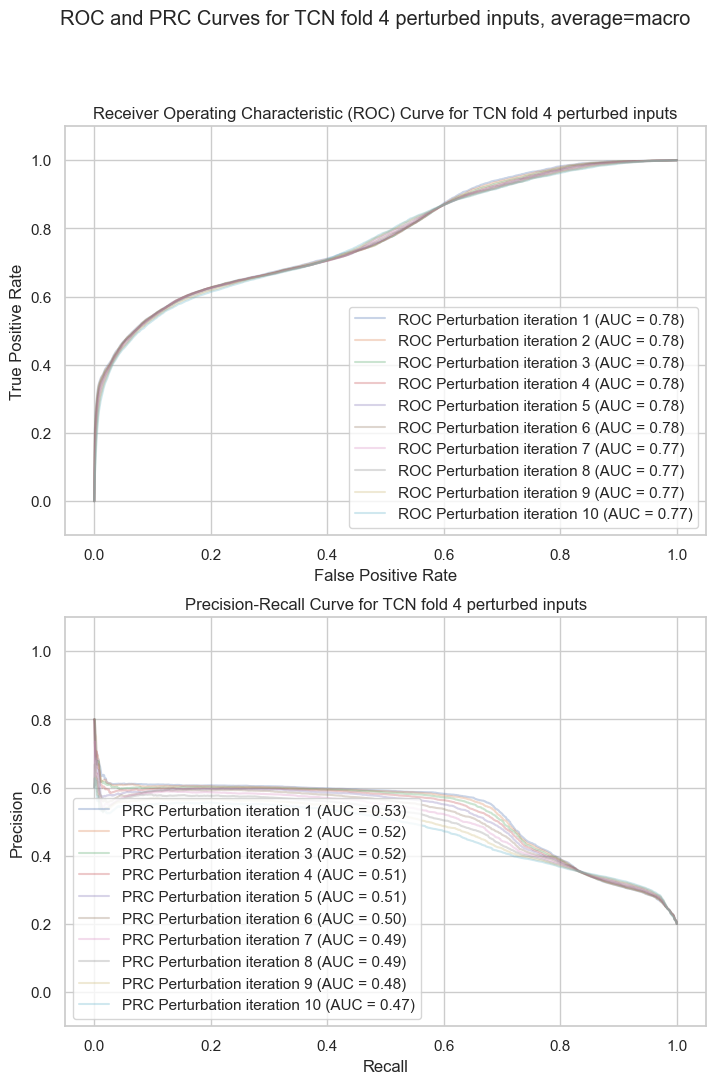

In [9]:
k_fold_roc_curve(model_outputs, "TCN fold 4 perturbed inputs", legend_key="Perturbation iteration", show_mean_and_std=False)

  0%|          | 0/10 [00:00<?, ?it/s]

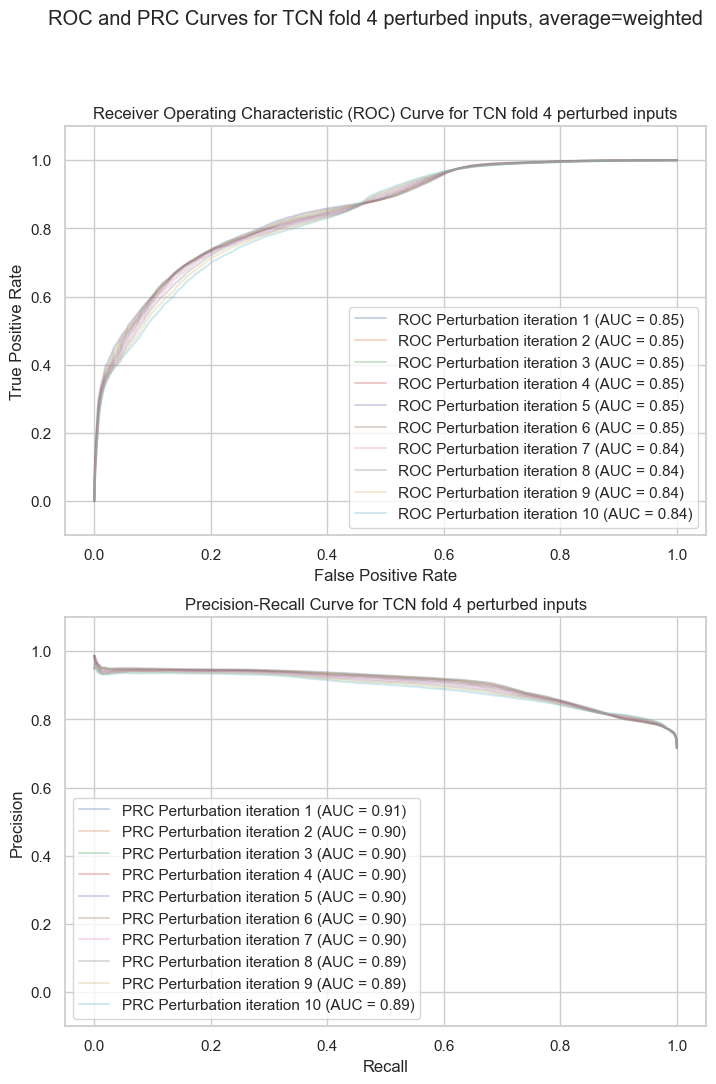

In [10]:
k_fold_roc_curve(model_outputs, "TCN fold 4 perturbed inputs", legend_key="Perturbation iteration", average="weighted", show_mean_and_std=False)